*Author*: **Kirill Karpenko** ([personal page on GitHub](https://github.com/mssrchapelier/))

# Amharic news headlines classification

## Introduction

This notebook describes the training, evaluation and application of an **Amharic news headlines classifier**.

* A [multinomial naïve Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes) is used as the classifier in this notebook.
* The use of [$\text{tf*idf}$ weighting](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is investigated here; see below for a comparison of a pipeline that doesn't weight token inputs against one that uses $\text{tf*idf}$ weighting.
* I have explored using tokens lemmatised with [HornMorpho](https://github.com/hltdi/HornMorpho) (a rule-based morphological analyser developed by [Michael Gasser](https://cgi.luddy.indiana.edu/~gasser/)\) as input; however, pipelines that use these tokens have so far yielded worse results than those that use non-lemmatised tokens and are not demonstrated here.

The pipelines are trained and tested on the [Amharic News Text Classification Dataset](https://github.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset). To assess the performance of the models, [$k$-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Non-exhaustive_cross-validation) is employed (with $k = 10$).

The results are visualised using `matplotlib`, `seaborn` and [`statannotations`](https://github.com/trevismd/statannotations).

## Loading resources

In [1]:
!pip install statannotations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/IsraelAbebe/An-Amharic-News-Text-classification-Dataset
!mv "./An-Amharic-News-Text-classification-Dataset/data/Amharic News Dataset.zip" "Amharic News Dataset.zip"
!rm -r "./An-Amharic-News-Text-classification-Dataset"
!unzip 'Amharic News Dataset.zip'
!rm 'Amharic News Dataset.zip'
!ls

Cloning into 'An-Amharic-News-Text-classification-Dataset'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
Archive:  Amharic News Dataset.zip
  inflating: Amharic News Dataset.csv  
'Amharic News Dataset.csv'   sample_data


In [3]:
from typing import Union, List, Dict, Tuple
from __future__ import annotations

import string, re
import json
from collections import defaultdict, Counter
from itertools import combinations

from tqdm.auto import tqdm

import numpy as np, pandas as pd
import scipy
from scipy.sparse import csr_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.exceptions import NotFittedError

from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt, seaborn as sns
from statannotations.Annotator import Annotator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading the dataset

In [4]:
DATASET_PATH = "Amharic News Dataset.csv"
LABELS_TRANSLATIONS = {"ሀገር አቀፍ ዜና": "Ethiopian news",
                       "ስፖርት": "sports",
                       "ፖለቲካ": "politics",
                       "ዓለም አቀፍ ዜና": "world news",
                       "ቢዝነስ": "business",
                       "መዝናኛ": "entertainment"}
SEED = 64091

Reading the dataset stored in `.csv`, removing unneeded columns as well as rows that contain empty strings or `NaN` values, and converting labels from Amharic to English for ease of use:

In [5]:
def read_dataset(in_path: str) -> pd.DataFrame:
    # read data from .csv into a DataFrame
    print("Reading file:", in_path)
    data = pd.read_csv(in_path)
    # remove columns that will not be used
    data = data.drop(columns=["date", "views", "article", "link"])
    # remove rows where headline, category and/or article
    # consist of whitespace entirely or are NaN
    print("Removing invalid entries...")
    data = data.loc[
        ~(
            (data.headline.str.isspace())
            | (data.category.str.isspace())
            | (pd.isna(data.headline))
            | (pd.isna(data.category))
        )
    ]
    data["category"] = data["category"].map(lambda x: LABELS_TRANSLATIONS[x])
    print("Done")
    return data

In [6]:
data = read_dataset(DATASET_PATH)

Reading file: Amharic News Dataset.csv
Removing invalid entries...
Done


In [7]:
data

,headline,category
0,የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል,sports
1,አዲስ ዘመን ድሮ,entertainment
2,የአረንጓዴ ጎርፍ በጎ አድራጎት አምባሳደሮች ተሰየሙ,sports
3,የሊጉ በቢዝነስ ሞዴል መመራት አበረታች ጅምር መሆኑ ተገለጸ,sports
4,የኦሊምፒክ ሥራ አስፈፃሚው እስከ ቶኪዮ ኦሊምፒክ ማግስት ይቀጥላል,sports
...,...,...
51478,የ2011 በጀት ዓመት የውጭ ዲሎማሲያዊ ተግባራት ስኬታማ እንደነበሩ ተገለጸ,politics
51479,አቶ አገኘሁ ተሻገር የሰላም ግንባታና የሕዝብ ደህንነት ኃላፊ ሆነው ተሾሙ,politics
51480,የአማራ ክልል ምክር ቤት የ230 ዳኞችን ሹመት አጸደቀ,politics
51481,ሃምሌ 22 ለሚካሄደው የችግኝ ተከላ መርሀ-ግብር 54 ሚሊየን ብር ተመድቧል,Ethiopian news


Checking the number of examples with each category in the dataset:

In [8]:
data["category"].value_counts()

Ethiopian news    20664
sports            10411
politics           9325
world news         6543
business           3894
entertainment       632
Name: category, dtype: int64

In [9]:
data["category"].value_counts(normalize=True)

Ethiopian news    0.401484
sports            0.202277
politics          0.181177
world news        0.127125
business          0.075657
entertainment     0.012279
Name: category, dtype: float64

Dividing the full dataset into the training and test sets. The proportions of each category in the full dataset will be preserved in the subsets.

In [10]:
def divide_dataset(full_dataset: pd.DataFrame, *,
                   test_frac: float, rand: np.random.RandomState) -> Tuple[pd.DataFrame, pd.DataFrame]:
    test_set = full_dataset.groupby("category").sample(frac=test_frac,
                                                       random_state=rand)
    train_set = full_dataset.drop(test_set.index)
    return train_set, test_set

We will use 10% of the full dataset for the test set.

In [11]:
train_set, test_set = divide_dataset(data, test_frac=0.1, rand=np.random.RandomState(SEED))

The resulting proportions in all sets:

In [12]:
print("\t".join(["{: ^15}".format("labels"),
                 *["{: ^9}".format(x) for x in ["full", "train", "test"]]]))
for item_full, item_train, item_test in zip(data["category"].value_counts(normalize=True).items(),
                                            train_set["category"].value_counts(normalize=True).items(),
                                            test_set["category"].value_counts(normalize=True).items()):
    label = item_full[0]
    frac_full, frac_train, frac_test = item_full[1], item_train[1], item_test[1]
    line = "\t".join(["{: <15}".format(label),
                      *["{: ^9.03f}".format(num) for num in [frac_full, frac_train, frac_test]]])
    print(line)

    labels     	  full   	  train  	  test   
Ethiopian news 	  0.401  	  0.401  	  0.402  
sports         	  0.202  	  0.202  	  0.202  
politics       	  0.181  	  0.181  	  0.181  
world news     	  0.127  	  0.127  	  0.127  
business       	  0.076  	  0.076  	  0.076  
entertainment  	  0.012  	  0.012  	  0.012  


## Tokenisation

Converting text strings into sequences of tokens:

In [13]:
PUNCTUATION = string.punctuation + "፠፡።፣፤፥፦፧፨‹›"

In [14]:
class Tokeniser:
    
    def __init__(self, *, separate_numbers=True, punct: str = PUNCTUATION):
        self._separate_numbers = separate_numbers
        self._punct = punct
        self._punct_pattern = re.compile("(" + "[" + self._punct + "]+" + ")")
        self._punct_repl = r" \1 "
        self._num_pattern = re.compile(r"(\d+)")
        self._num_repl = r" \1 "
    
    def __call__(self, texts: List[str]) -> List[List[str]]:
        """
        Processes each raw text (str) in texts into a list of tokens.
        """
        return [self._process_single_text(text)
                for text in tqdm(texts, desc="Tokenising...", leave=False)]
    
    def _process_single_text(self, text: str) -> List[str]:
        text = self._punct_pattern.sub(self._punct_repl, text)
        if self._separate_numbers:
            text = self._num_pattern.sub(self._num_repl, text)
        tokens = text.split()
        return tokens

## Preprocessing

Optional step: deleting tokens that do not consist of letters or digits (`only_alpha_or_digit`), substituting a placeholder for all punctuation marks (`transform_punct`), or a different placeholder for all numbers (`transform_digits`).

In [15]:
class Preprocessor:
    
    _digit_placeholder = "<DIGIT>"
    _punct_placeholder = "<PUNCT>"
    
    def __init__(self, *, only_alpha_or_digit=False,
                 transform_digits=True, transform_punct=False, punct: str = PUNCTUATION):
        self._only_alpha_or_digit = only_alpha_or_digit
        self._transform_digits = transform_digits
        self._transform_punct = transform_punct
        self._punct = punct
        # tokens consisting of 1 or more punctuation marks entirely
        self._punct_pattern = re.compile("^" + "[" + self._punct + "]+" + "$")
    
    def __call__(self, texts: List[List[str]]) -> List[List[str]]:
        return [self._process_single_text(text)
                for text in tqdm(texts, desc="Preprocessing...", leave=False)]
    
    def _process_single_text(self, tokens: List[str]) -> List[str]:
        """
        Performs preprocessing on a list of string tokens.
        """
        if self._only_alpha_or_digit:
            tokens = [token for token in tokens
                      if token.isalpha() or token.isdigit()]
        elif self._transform_punct:
            tokens = [Preprocessor._punct_placeholder
                      if self._is_punct(token) else token
                      for token in tokens]
        if self._transform_digits:
            tokens = [Preprocessor._digit_placeholder
                      if token.isdigit() else token
                      for token in tokens]
        return tokens
    
    def _is_punct(self, token: str) -> bool:
        """
        determines if a token consists of punctuation marks entirely
        """
        return bool(self._punct_pattern.match(token))

## Vectorising

Generating vectors from sequences of tokens.

Vectors have length equal to the number of unique tokens that occur more that `min_count` times in the training set. If `use_tfidf` is `False`, the value of the $i$-th coordinate is the number of occurrences of the $i$-th word in the text (i. e. its term frequency, $\text{tf}$); if `use_tfidf` is `True`, this value is weighted by the inverse document frequency of the $i$-th word:
$$ idf_i = log\frac{N}{df_i},$$
where $N$ is the number of texts in the training set, $df_i$ is the number of documents that contain the $i$-th word.

The parameter `use_csr` (`True` by default) specifies the use of [compressed sparse row matrices](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)) to facilitate fast matrix operations, which is beneficial for performance (especially when using $\text{tf*idf}$ weighting) since the resulting vectors are very sparse (the vast majority of coordinate values equal 0, because only a small number of words from the dictionary appear in any given text).

In [16]:
class Vectoriser:
    
    def __init__(self, *, min_count=3, use_tfidf=False, use_csr=True):
        self.min_count = 3
        self._use_tfidf = use_tfidf
        self._use_csr = use_csr
        self.symbols = None
        self.symbol_codes = None
        self._idfs = None
    
    def fit(self, data: List[List[str]]) -> Vectoriser:
        self._build_dict(data)
        if self._use_tfidf:
            self._idfs = self._compute_idfs(data)
        return self
    
    def __call__(self, data: List[List[str]]) -> Union[np.ndarray, csr_matrix]:
        if (self.symbols is None
            or self.symbol_codes is None
            or (self._use_tfidf and (self._idfs is None))):
            raise NotFittedError()
        count_matrix = self._compute_count_matrix(data)
        if self._use_tfidf:
            return (count_matrix.multiply(self._idfs)
                    if self._use_csr
                    else np.multiply(count_matrix, self._idfs))
        else:
            return count_matrix
    
    def _build_dict(self, data: List[List[str]]) -> Vectoriser:
        counts = defaultdict(int)
        for text in tqdm(data, desc="Building count dictionary...", leave=False):
            for token in text:
                counts[token] += 1
        # filter out all tokens with count<min_count
        self.symbols = [token for token, count in counts.items()
                        if count >= self.min_count]
        self.symbol_codes = {token: i for i, token in enumerate(self.symbols)}
        return self
    
    def _compute_idfs(self, data: List[List[str]]) -> np.ndarray:
        if not self._use_tfidf:
            raise ValueError("This function is meant to be used to compute idf weights, \
            but the ._use_tfidf attribute of this Vectoriser instance is set to False.")
        dfs = self._compute_dfs(data)
        # using formula: idf = log10(N/df)
        return np.log10(len(data) * np.reciprocal(dfs))
    
    def _compute_dfs(self, data: List[List[str]]) -> np.ndarray:
        count_matrix = self._compute_count_matrix(data)
        if self._use_csr:
            _, nonzero_cols = count_matrix.nonzero()
            # assumption: there are no zero dfs for any token
            # (all tokens have been included in self._symbols)
            return np.array([df for token_code, df in Counter(nonzero_cols).items()]).astype(float)
        else:
            return np.count_nonzero(count_matrix, axis=0).astype(float)
    
    def _get_count_vector(self, text: List[str]) -> np.ndarray:
        if self._use_csr:
            raise ValueError("Computing the count vector for a single text \
            is not defined for a vectoriser that uses CSR matrix computations.")
        if self.symbols is None or self.symbol_codes is None:
            raise NotFittedError("This vectoriser's dictionary (.symbols \
            and .symbol_codes) has not been built yet.")
        # returns the count vector for a single text
        vector = [0.] * len(self.symbols)
        count_dict = Counter(text)
        for token, count in count_dict.items():
            code = self.symbol_codes.get(token)
            if code is not None:
                vector[code] += count
        return np.array(vector)
    
    def _compute_count_matrix(self, data: List[str]) -> Union[np.ndarray, csr_matrix]:
        if self.symbols is None or self.symbol_codes is None:
            raise NotFittedError("This vectoriser's dictionary (.symbols \
            and .symbol_codes) has not been built yet.")
        if not self._use_csr:
            return np.array([self._get_count_vector(text) for text in data])
        else:
            # compute as a CSR matrix
            values, rows, columns = [], [], []
            for text_counter, text in enumerate(data):
                count_dict = Counter(text)
                for token, count in count_dict.items():
                    code = self.symbol_codes.get(token)
                    if code is not None:
                        values.append(count)
                        rows.append(text_counter)
                        columns.append(code)
            return csr_matrix((values, (rows, columns)),
                              shape=(len(data), len(self.symbols)),
                              dtype=float)

## Pipelines

Combining all the previous steps (along with a classifier) in a pipeline object that has methods to train it on a collection of raw texts and labels (`.train()`) and to predict labels from raw texts (`.predict()`):

In [17]:
class ClassificationPipeline:
    def __init__(self, *, tokeniser: Tokeniser, preprocessor: Preprocessor,
                 vectoriser: Vectoriser, classifier, descr: str = None):
        self.tokeniser = tokeniser
        self.preprocessor = preprocessor
        self.vectoriser = vectoriser
        self.classifier = classifier
        self.descr = descr
    
    def train(self, *, raw_texts: List[str], labels: List[str]) -> ClassificationPipeline:
        texts = self.tokeniser(raw_texts)
        texts = self.preprocessor(texts)
        self.vectoriser.fit(texts)
        vectors = self.vectoriser(texts)
        self.classifier.fit(vectors, labels)
        return self
    
    def predict(self, raw_texts: List[str], *, return_distributions=False, get_results_as_text=False) -> tuple:
        # validating arguments
        if get_results_as_text:
            return_distributions = True
        # validating state
        if None in [self.preprocessor, self.vectoriser, self.classifier]:
            raise ValueError("The preprocessor, vectoriser and/or classifier have not been initialised.")
        
        texts = self.tokeniser(raw_texts)
        texts = self.preprocessor(texts)
        vectors = self.vectoriser(texts)
        pred_labels = self.classifier.predict(vectors) # List[str]
        prob_distributions = self.classifier.predict_proba(vectors)
        # converting to form: {"class_1": prob_1, ..., "class_n": prob_n}
        prob_distributions = [{class_name: prob
                               for class_name, prob
                               in zip(list(self.classifier.classes_), distr)}
                              for distr in prob_distributions] # List[Dict[str, float]]
        predictions_as_text = [self._single_prediction_to_text(raw_text=raw_text,
                                                               pred_class=label,
                                                               prob_distr=distr)
                               for raw_text, label, distr in zip(raw_texts,
                                                                 pred_labels,
                                                                 prob_distributions)] # List[str]
        if get_results_as_text:
            return pred_labels, prob_distributions, predictions_as_text
        elif return_distributions:
            return pred_labels, prob_distributions
        else:
            return pred_labels
    
    def _single_prediction_to_text(self, *,
                                   raw_text: str,
                                   pred_class: str,
                                   prob_distr: Dict[str, float]) -> str:
        output = ""
        truncated_text = raw_text[0:50] + "..." if len(raw_text) > 50 else raw_text
        output += "text: {}".format(truncated_text) + "\n"
        if self.descr is not None:
            output += "{:-^50}".format("pipeline: " + self.descr) + "\n"
        output += "predicted class: {}".format(pred_class) + "\n"
        output += "class probabilities: "
        output += "\t".join(["{}: {:.2%}".format(class_name, prob)
                             for class_name, prob in prob_distr.items()]) + "\n"
        return output

Creating pipelines using vectorisers without (`pipeline_no_tfidf`) and with (`pipeline_with_tfidf`) $\text{tf*idf}$ weighting:

In [18]:
pipeline_no_tfidf = ClassificationPipeline(tokeniser=Tokeniser(),
                                           preprocessor=Preprocessor(),
                                           vectoriser=Vectoriser(),
                                           classifier=MultinomialNB(),
                                           descr="no_tfidf")

In [19]:
pipeline_with_tfidf = ClassificationPipeline(tokeniser=Tokeniser(),
                                        preprocessor=Preprocessor(),
                                        vectoriser=Vectoriser(use_tfidf=True),
                                        classifier=MultinomialNB(),
                                        descr="with_tfidf")

## $k$-fold cross-validation

Performing **$k$-fold cross-validation** using the training set to obtain averaged metric values: the rows in the dataset are shuffled and divided into $k$ equal non-overlapping parts that will be used as the dev set during each run, the rest being used as the training set. We ensure that the proportion of each category is preserved in the both subsets in all folds to obtain comparable sets.

In [20]:
def test_pipeline(*, pipeline: ClassificationPipeline,
                  true_labels: List[str],
                  test_rawtexts: List[str]) -> Tuple[float, Dict[str, Dict[str, float]]]:
    """
    Returns:
    acc: float,
    prf1:
    { "precision": {"label_1": float, ...},
      "recall": {"label_1": float, ...},
      "f1": {"label_1": float, ...} }
    """
    pred_labels = pipeline.predict(raw_texts=test_rawtexts)
    acc = accuracy_score(true_labels, pred_labels)
    prf1 = {"precision": None, "recall": None, "f1": None} # Dict[str, float]
    prf1["precision"], prf1["recall"], prf1["f1"], _ = precision_recall_fscore_support(true_labels,
                                                                                       pred_labels)
    for metric_name in prf1:
        # e.g. metrics["f1"] = {"class_1": [... values ...], ..., "class_i": ...}
        prf1[metric_name] = {label: value for label, value in zip(pipeline.classifier.classes_,
                                                                  prf1[metric_name])}
    return acc, prf1

In [21]:
def kfold_validate(*, pipeline: ClassificationPipeline,
                   dataset: pd.DataFrame,
                   k: int,
                   rand: np.random.RandomState) -> dict:
    
    """
    Returns:
    results_acc: List[float] (accuracy values for each of the k runs),
    results_prf1: Dict[str, Dict[str, List[float]]], where
      results_prf1[metric_name][category_label]
    is a List[float] of individual observations of metric_name
    for category_label for each of the k runs .
    """
    
    def _get_folds_indices() -> List[np.ndarray]:
        """
        Calculates sets of indices for k dev sets.
        The proportion of each category in the full dataset is preserved in each set.
        """
        dev_frac = 1 / k
        # get indices for each category
        category_indices = dataset.groupby("category").indices # Dict[str, np.ndarray]
        # shuffle each index array
        for indices in category_indices.values(): # np.ndarray
            rand.shuffle(indices)
        # split each array into k folds: {"label_1": [fold_1, ..., fold_k], ...}
        category_folds = {label: np.array_split(indices, k)
                          for label, indices in category_indices.items()} # Dict[str, List[np.ndarray]]
        # for i-th fold (over all categories), find i-th fold for each category
        # and concatenate them
        folds = [np.concatenate([category_folds[label][i]
                                 for label in category_folds.keys()])
                 for i in range(k)] # List[np.ndarray]
        assert len(folds) == k
        return folds
    
    if k > len(dataset):
        raise ValueError(("Can't partition the dataset of length {}"
                          "into {} folds").format(k, len(dataset)))
    print(("Validating: k-fold cross-validation (k = {}).\n"
           "The original category proportions are preserved in each fold.").format(k))
    results_acc = []
    results_prf1 = {"precision": defaultdict(list),
                    "recall": defaultdict(list),
                    "f1": defaultdict(list)}
    
    folds_indices = _get_folds_indices() # List[np.ndarray]
    for i in tqdm(range(k), desc="folds...", leave=False):
        dev_set = dataset.iloc[folds_indices[i]]
        train_set = dataset.drop(dev_set.index)
        pipeline.train(raw_texts=train_set["headline"].tolist(),
                       labels=train_set["category"].tolist())
        fold_acc, fold_prf1 = test_pipeline(pipeline=pipeline,
                                            test_rawtexts=dev_set["headline"].tolist(),
                                            true_labels=dev_set["category"].tolist())
        results_acc.append(fold_acc)
        for metric_name in fold_prf1:
            for label in pipeline.classifier.classes_:
                # e. g. results_prf1["recall"]["class_i"]
                results_prf1[metric_name][label].append(fold_prf1[metric_name][label])
            results_prf1[metric_name] = dict(results_prf1[metric_name])
    print("Done")
    return results_acc, results_prf1

In [22]:
def display_kfold_results(metrics_acc: List[float],
                          metrics_prf1: Dict[str, Dict[str, List[float]]],
                          *,
                          p: float = 0.05,
                          with_conf_intervals=True) -> None:
    
    k = len(metrics_acc)
    
    text_output = ""
    text_output += "Results, k-fold cross-validation (k = {})\n\n".format(k)
    
    # --- accuracy ---
    text_output += "Accuracy:\n"
    descrstats_acc = DescrStatsW(metrics_acc)
    mean_acc = descrstats_acc.mean
    std_acc = descrstats_acc.std
    conf_int_acc = descrstats_acc.tconfint_mean(alpha=p)
    # conf_int == mean ± h
    h_acc = (conf_int_acc[1] - conf_int_acc[0]) / 2
    
    text_output += ("mean: {:.03f} ± {:.03f} (p = {:.2f})\t".format(mean_acc, h_acc, p)
                    if with_conf_intervals
                    else "mean: {:.03f}\t".format(mean_acc))
    text_output += "std: {:.03f}".format(std_acc)
    text_output += "\n"
    
    # --- class-wise P, R, F1 ---
    text_output += "\t".join(["{: ^15}".format("labels"),
                              *["{: ^13}".format(metric_name)
                                for metric_name in metrics_prf1]])
    for label in metrics_prf1["precision"]: # for each category label
        row_text = "{: ^15}".format(label)
        for metric_name in metrics_prf1:
            descrstats = DescrStatsW(metrics_prf1[metric_name][label])
            mean = descrstats.mean
            conf_int = descrstats.tconfint_mean(alpha=p)
            # conf_int == mean ± h
            h = (conf_int[1] - conf_int[0]) / 2
            cell_text = ("{:.03f} ± {:.03f}".format(mean, h)
                         if with_conf_intervals
                         else "{: ^13.03f}".format(mean))
            row_text += "\t" + cell_text
        text_output += "\n" + row_text
    print(text_output)

In [23]:
kfold_results = dict()
for pipeline in [pipeline_no_tfidf, pipeline_with_tfidf]:
    acc, prf1 = kfold_validate(pipeline=pipeline,
                               dataset=train_set,
                               k=10,
                               rand=np.random.RandomState(SEED))
    kfold_results[pipeline.descr] = {"acc": acc, "prf1": prf1}

Validating: k-fold cross-validation (k = 10).
The original category proportions are preserved in each fold.


folds...:   0%|          | 0/10 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41691 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41691 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41691 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4633 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4633 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41691 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41691 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41691 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4633 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4633 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41693 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41693 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41693 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4631 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4631 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41695 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41695 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41695 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4629 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4629 [00:00<?, ?it/s]

Done
Validating: k-fold cross-validation (k = 10).
The original category proportions are preserved in each fold.


folds...:   0%|          | 0/10 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41690 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41690 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41690 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4634 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4634 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41691 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41691 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41691 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4633 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4633 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41691 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41691 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41691 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4633 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4633 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41692 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41692 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41692 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4632 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4632 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41693 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41693 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41693 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4631 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4631 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/41695 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/41695 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/41695 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4629 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4629 [00:00<?, ?it/s]

Done


In [24]:
print(kfold_results)

{'no_tfidf': {'acc': [0.7157962883038411, 0.7073802330599913, 0.7060854553301683, 0.7086121303690913, 0.7194042736887546, 0.7083333333333334, 0.7104922279792746, 0.7087651122625216, 0.7132368818829626, 0.7146251890257075], 'prf1': {'precision': {'Ethiopian news': [0.7316276537833424, 0.7232289950576606, 0.7294182217343579, 0.7263626251390434, 0.7297297297297297, 0.7192038730500269, 0.732744340143567, 0.718562874251497, 0.7343234323432343, 0.7280130293159609], 'business': [0.5126436781609195, 0.45662100456621, 0.4230769230769231, 0.5078651685393258, 0.46741573033707867, 0.494199535962877, 0.4605263157894737, 0.5259433962264151, 0.49061032863849763, 0.5025252525252525], 'entertainment': [1.0, 0.3333333333333333, 0.23076923076923078, 0.2222222222222222, 0.2, 0.0, 0.3333333333333333, 0.5, 0.5714285714285714, 0.4], 'politics': [0.548460661345496, 0.5580046403712297, 0.5659928656361475, 0.54524627720504, 0.5860023724792408, 0.5683192261185006, 0.5676646706586826, 0.5514450867052023, 0.552188

In [25]:
for pipeline in [pipeline_no_tfidf, pipeline_with_tfidf]:
    descr = pipeline.descr
    acc = kfold_results[descr]["acc"]
    prf1 = kfold_results[descr]["prf1"]
    print("{:*^30}".format(pipeline.descr))
    display_kfold_results(acc, prf1, with_conf_intervals=True)
    print("")

***********no_tfidf***********
Results, k-fold cross-validation (k = 10)

Accuracy:
mean: 0.711 ± 0.003 (p = 0.05)	std: 0.004
    labels     	  precision  	   recall    	     f1      
Ethiopian news 	0.727 ± 0.004	0.715 ± 0.005	0.721 ± 0.004
   business    	0.484 ± 0.023	0.599 ± 0.025	0.535 ± 0.023
 entertainment 	0.379 ± 0.194	0.035 ± 0.013	0.062 ± 0.023
   politics    	0.561 ± 0.009	0.573 ± 0.007	0.567 ± 0.006
    sports     	0.945 ± 0.005	0.929 ± 0.005	0.937 ± 0.004
  world news   	0.687 ± 0.012	0.680 ± 0.011	0.683 ± 0.010

**********with_tfidf**********
Results, k-fold cross-validation (k = 10)

Accuracy:
mean: 0.690 ± 0.003 (p = 0.05)	std: 0.004
    labels     	  precision  	   recall    	     f1      
Ethiopian news 	0.771 ± 0.003	0.615 ± 0.007	0.684 ± 0.005
   business    	0.418 ± 0.015	0.698 ± 0.021	0.522 ± 0.017
 entertainment 	0.203 ± 0.021	0.311 ± 0.036	0.245 ± 0.024
   politics    	0.543 ± 0.008	0.581 ± 0.011	0.562 ± 0.007
    sports     	0.954 ± 0.004	0.929 ± 0.005	0.942 ±

In [26]:
def display_kfold_boxplots(kfold_results: dict) -> None:
    """
    acc_arr, prf1_arr: arrays of kfold_acc, kfold_prf1 values for each pipeline
    desc_arr: descr of each pipeline
    """

    acc_arr = [kfold_results[descr]["acc"] for descr in kfold_results]
    prf1_arr = [kfold_results[descr]["prf1"] for descr in kfold_results]
    desc_arr = list(kfold_results.keys())

    assert len(acc_arr) == len(prf1_arr)
    assert len(desc_arr) == len(prf1_arr)
    
    # number of pipelines
    num_pipelines = len(acc_arr)
    
    # number of folds
    k = len(acc_arr[1])
    
    def _tidify() -> pd.DataFrame:
        """
        Explodes input data into a "tidy" dataframe for use with seaborn.
        """
        data = []
        for i in range(num_pipelines):
            desc = desc_arr[i]
            for acc_value in acc_arr[i]:
                data.append({"category": None,
                             "metric": "accuracy",
                             "pipeline": desc,
                             "value": acc_value})
            for metric_name in prf1_arr[i]:
                for label in prf1_arr[i][metric_name]:
                    values = prf1_arr[i][metric_name][label]
                    for value in values:
                        data.append({"category": label,
                                     "metric": metric_name,
                                     "pipeline": desc,
                                     "value": value})
        return pd.DataFrame(data)
    
    
    # --- drawing plots ---
    
    tidy = _tidify()
    tidy_acc = tidy.loc[tidy["metric"] == "accuracy"]
    tidy_prf1 = tidy.drop(tidy_acc.index)
    
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.dpi'] = 150
    # fig_width, fig_height = 11.69, 8.27 # A4
    fig_width, fig_height = 16.53, 11.69 # A3
    
    fig, axs = plt.subplots(nrows=4, figsize=(fig_width, fig_height),
                            constrained_layout=True)
    fig.suptitle("Results ({}-fold cross-validation)".format(k))
    # --- accuracy ---
    # pairs: paired t-test will be performed to compare metrics
    # between these pairs of pipelines
    pairs_acc = list(combinations(desc_arr, 2))
    axs[0].title.set_text("accuracy")
    sns.boxplot(x="value", y="pipeline", data=tidy_acc, ax=axs[0], width=0.2)
    # performing t-test for each pair
    # and annotating pairs of boxplots with p-values
    annot_acc = Annotator(axs[0], pairs_acc, data=tidy_acc,
                          x="value", y="pipeline", orient="h", verbose=0)
    annot_acc.configure(test="t-test_paired", text_format="star", loc="inside")
    annot_acc.apply_and_annotate()
    # --- P, R, F1 ---
    order = list(tidy_prf1["category"].unique())
    # calculating pairs for t-test (for each category, pipeline 1 vs pipeline 2)
    pairs = []
    for category in order:
        for pipe_desc_1, pipe_desc_2 in pairs_acc:
            pairs.append(((category, pipe_desc_1), (category, pipe_desc_2)))
    for i, metric_name in zip([1, 2, 3], ["precision", "recall", "f1"]):
        # drawing a plot for each metric
        ax=axs[i]
        axs[i].title.set_text(metric_name)
        sns.boxplot(x="value", y="category", hue="pipeline", order=order,
                    data=tidy_prf1.loc[tidy_prf1["metric"] == metric_name],
                    ax=ax)
        # performing t-test for each of the pairs
        # and annotating pairs of boxplots with p-values
        annot = Annotator(ax, pairs,
                          data=tidy_prf1[tidy_prf1["metric"] == metric_name],
                          x="value", y="category", hue="pipeline",
                          order=order, orient="h", verbose=0)
        annot.configure(test="t-test_paired", text_format="star", loc="inside")
        annot.apply_and_annotate()
    for ax in axs:
        ax.set_xticks(np.arange(0, 1, 0.05))
    plt.show()

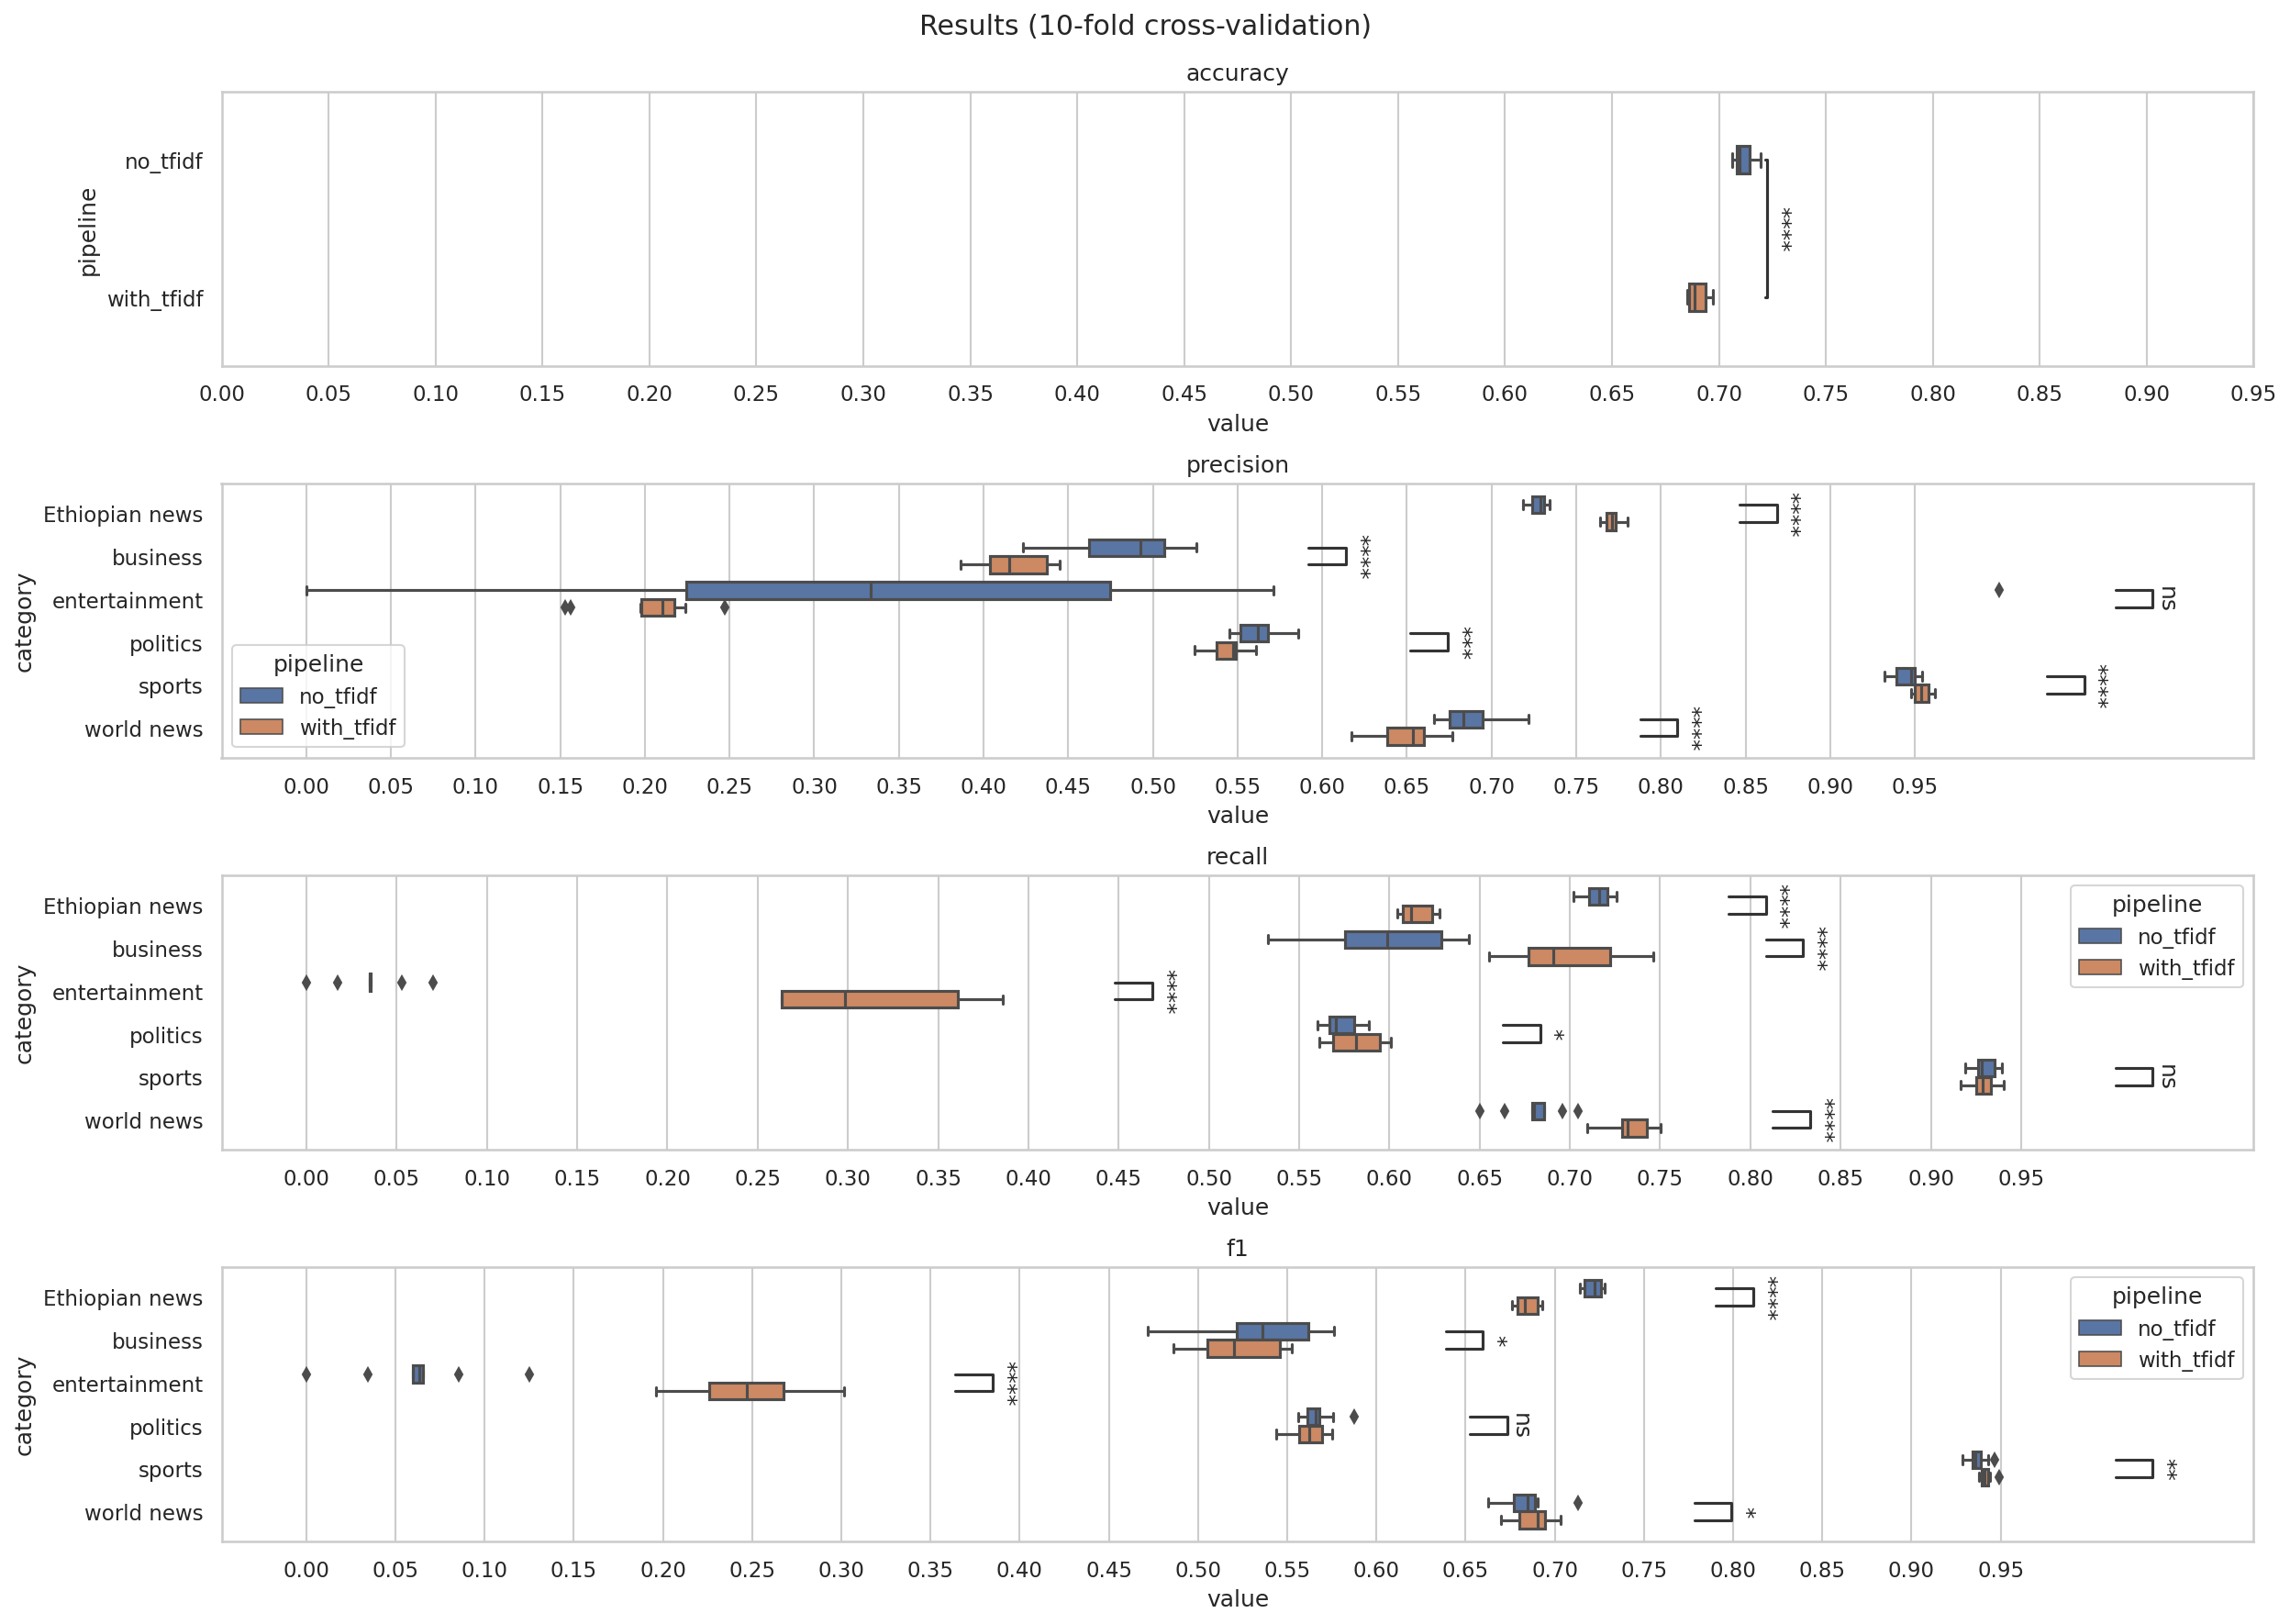

In [27]:
display_kfold_boxplots(kfold_results)

In [28]:
train_set.value_counts("category")

category
Ethiopian news    18598
sports             9370
politics           8393
world news         5889
business           3505
entertainment       569
dtype: int64

## Training (using the full training set)

In [29]:
for pipeline in [pipeline_no_tfidf, pipeline_with_tfidf]:
    pipeline.train(raw_texts=train_set["headline"].tolist(),
                   labels=train_set["category"].tolist())

Tokenising...:   0%|          | 0/46324 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/46324 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/46324 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/46324 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/46324 [00:00<?, ?it/s]

Building count dictionary...:   0%|          | 0/46324 [00:00<?, ?it/s]

## Evaluation

Running the pipeline on the test set and obtaining values for **accuracy** and category-wise **precision**, **recall** and **F1 score**:

In [30]:
acc_no_tfidf, prf1_no_tfidf = test_pipeline(pipeline=pipeline_no_tfidf,
                                            true_labels=test_set["category"].tolist(),
                                            test_rawtexts=test_set["headline"].tolist())
acc_with_tfidf, prf1_with_tfidf = test_pipeline(pipeline=pipeline_with_tfidf,
                                                true_labels=test_set["category"].tolist(),
                                                test_rawtexts=test_set["headline"].tolist())

Tokenising...:   0%|          | 0/5145 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/5145 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/5145 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/5145 [00:00<?, ?it/s]

In [31]:
def display_results(*, acc: float, prf1: dict) -> None:
    text_output = ""
    text_output += "Accuracy: {:.03f}".format(acc)
    text_output += "\n"
    
    text_output += "\t".join(["{: ^15}".format("labels"),
                              *["{: ^13}".format(metric_name)
                              for metric_name in prf1]])
    for label in prf1["precision"]: # for each category label
        row_text = "{: ^15}".format(label)
        for metric_name in prf1:
            cell_text = "{: ^13.03f}".format(prf1[metric_name][label])
            row_text += "\t" + cell_text
        text_output += "\n" + row_text
    print(text_output)

In [32]:
print(pipeline_no_tfidf.descr)
display_results(acc=acc_no_tfidf, prf1=prf1_no_tfidf)

no_tfidf
Accuracy: 0.721
    labels     	  precision  	   recall    	     f1      
Ethiopian news 	    0.735    	    0.718    	    0.726    
   business    	    0.482    	    0.589    	    0.530    
 entertainment 	    0.615    	    0.127    	    0.211    
   politics    	    0.567    	    0.594    	    0.580    
    sports     	    0.960    	    0.933    	    0.946    
  world news   	    0.710    	    0.705    	    0.708    


In [33]:
print(pipeline_with_tfidf.descr)
display_results(acc=acc_with_tfidf, prf1=prf1_with_tfidf)

with_tfidf
Accuracy: 0.697
    labels     	  precision  	   recall    	     f1      
Ethiopian news 	    0.769    	    0.606    	    0.678    
   business    	    0.417    	    0.681    	    0.518    
 entertainment 	    0.260    	    0.429    	    0.323    
   politics    	    0.555    	    0.612    	    0.582    
    sports     	    0.960    	    0.936    	    0.947    
  world news   	    0.675    	    0.758    	    0.714    


In [34]:
def display_results_comparative(*, acc_arr: list,
                                prf1_arr: list,
                                desc_arr: list) -> None:
    
    assert len(acc_arr) == len(prf1_arr)
    assert len(desc_arr) == len(prf1_arr)
    
    # number of pipelines
    num_pipelines = len(acc_arr)
    
    def _tidify() -> pd.DataFrame:
        """
        Explodes input data into a "tidy" dataframe for use with seaborn.
        """
        data = []
        for i in range(num_pipelines):
            desc = desc_arr[i]
            data.append({"category": None,
                         "metric": "accuracy",
                         "pipeline": desc,
                         "value": acc_arr[i]})
            for metric_name in prf1_arr[i]:
                for label in prf1_arr[i][metric_name]:
                    value = prf1_arr[i][metric_name][label]
                    data.append({"category": label,
                                 "metric": metric_name,
                                 "pipeline": desc,
                                 "value": value})
        return pd.DataFrame(data)
    
    
    # --- drawing plots ---
    
    tidy = _tidify()
    tidy_acc = tidy.loc[tidy["metric"] == "accuracy"]
    tidy_prf1 = tidy.drop(tidy_acc.index)
    
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.dpi'] = 150
    # fig_width, fig_height = 11.69, 8.27 # A4
    fig_width, fig_height = 16.53, 11.69 # A3
    
    fig, axs = plt.subplots(nrows=4, figsize=(fig_width, fig_height),
                            constrained_layout=True)
    # --- accuracy ---
    axs[0].title.set_text("accuracy")
    sns.barplot(x="value", y="pipeline", data=tidy_acc, ax=axs[0])
    # --- P, R, F1 ---
    for i, metric_name in zip([1, 2, 3], ["precision", "recall", "f1"]):
        # drawing a plot for each metric
        ax=axs[i]
        ax.title.set_text(metric_name)
        sns.barplot(x="value", y="category", hue="pipeline",
                    data=tidy_prf1.loc[tidy_prf1["metric"] == metric_name],
                    ax=ax)
    for ax in axs:
        ax.set_xticks(np.arange(0, 1, 0.05))
    plt.show()

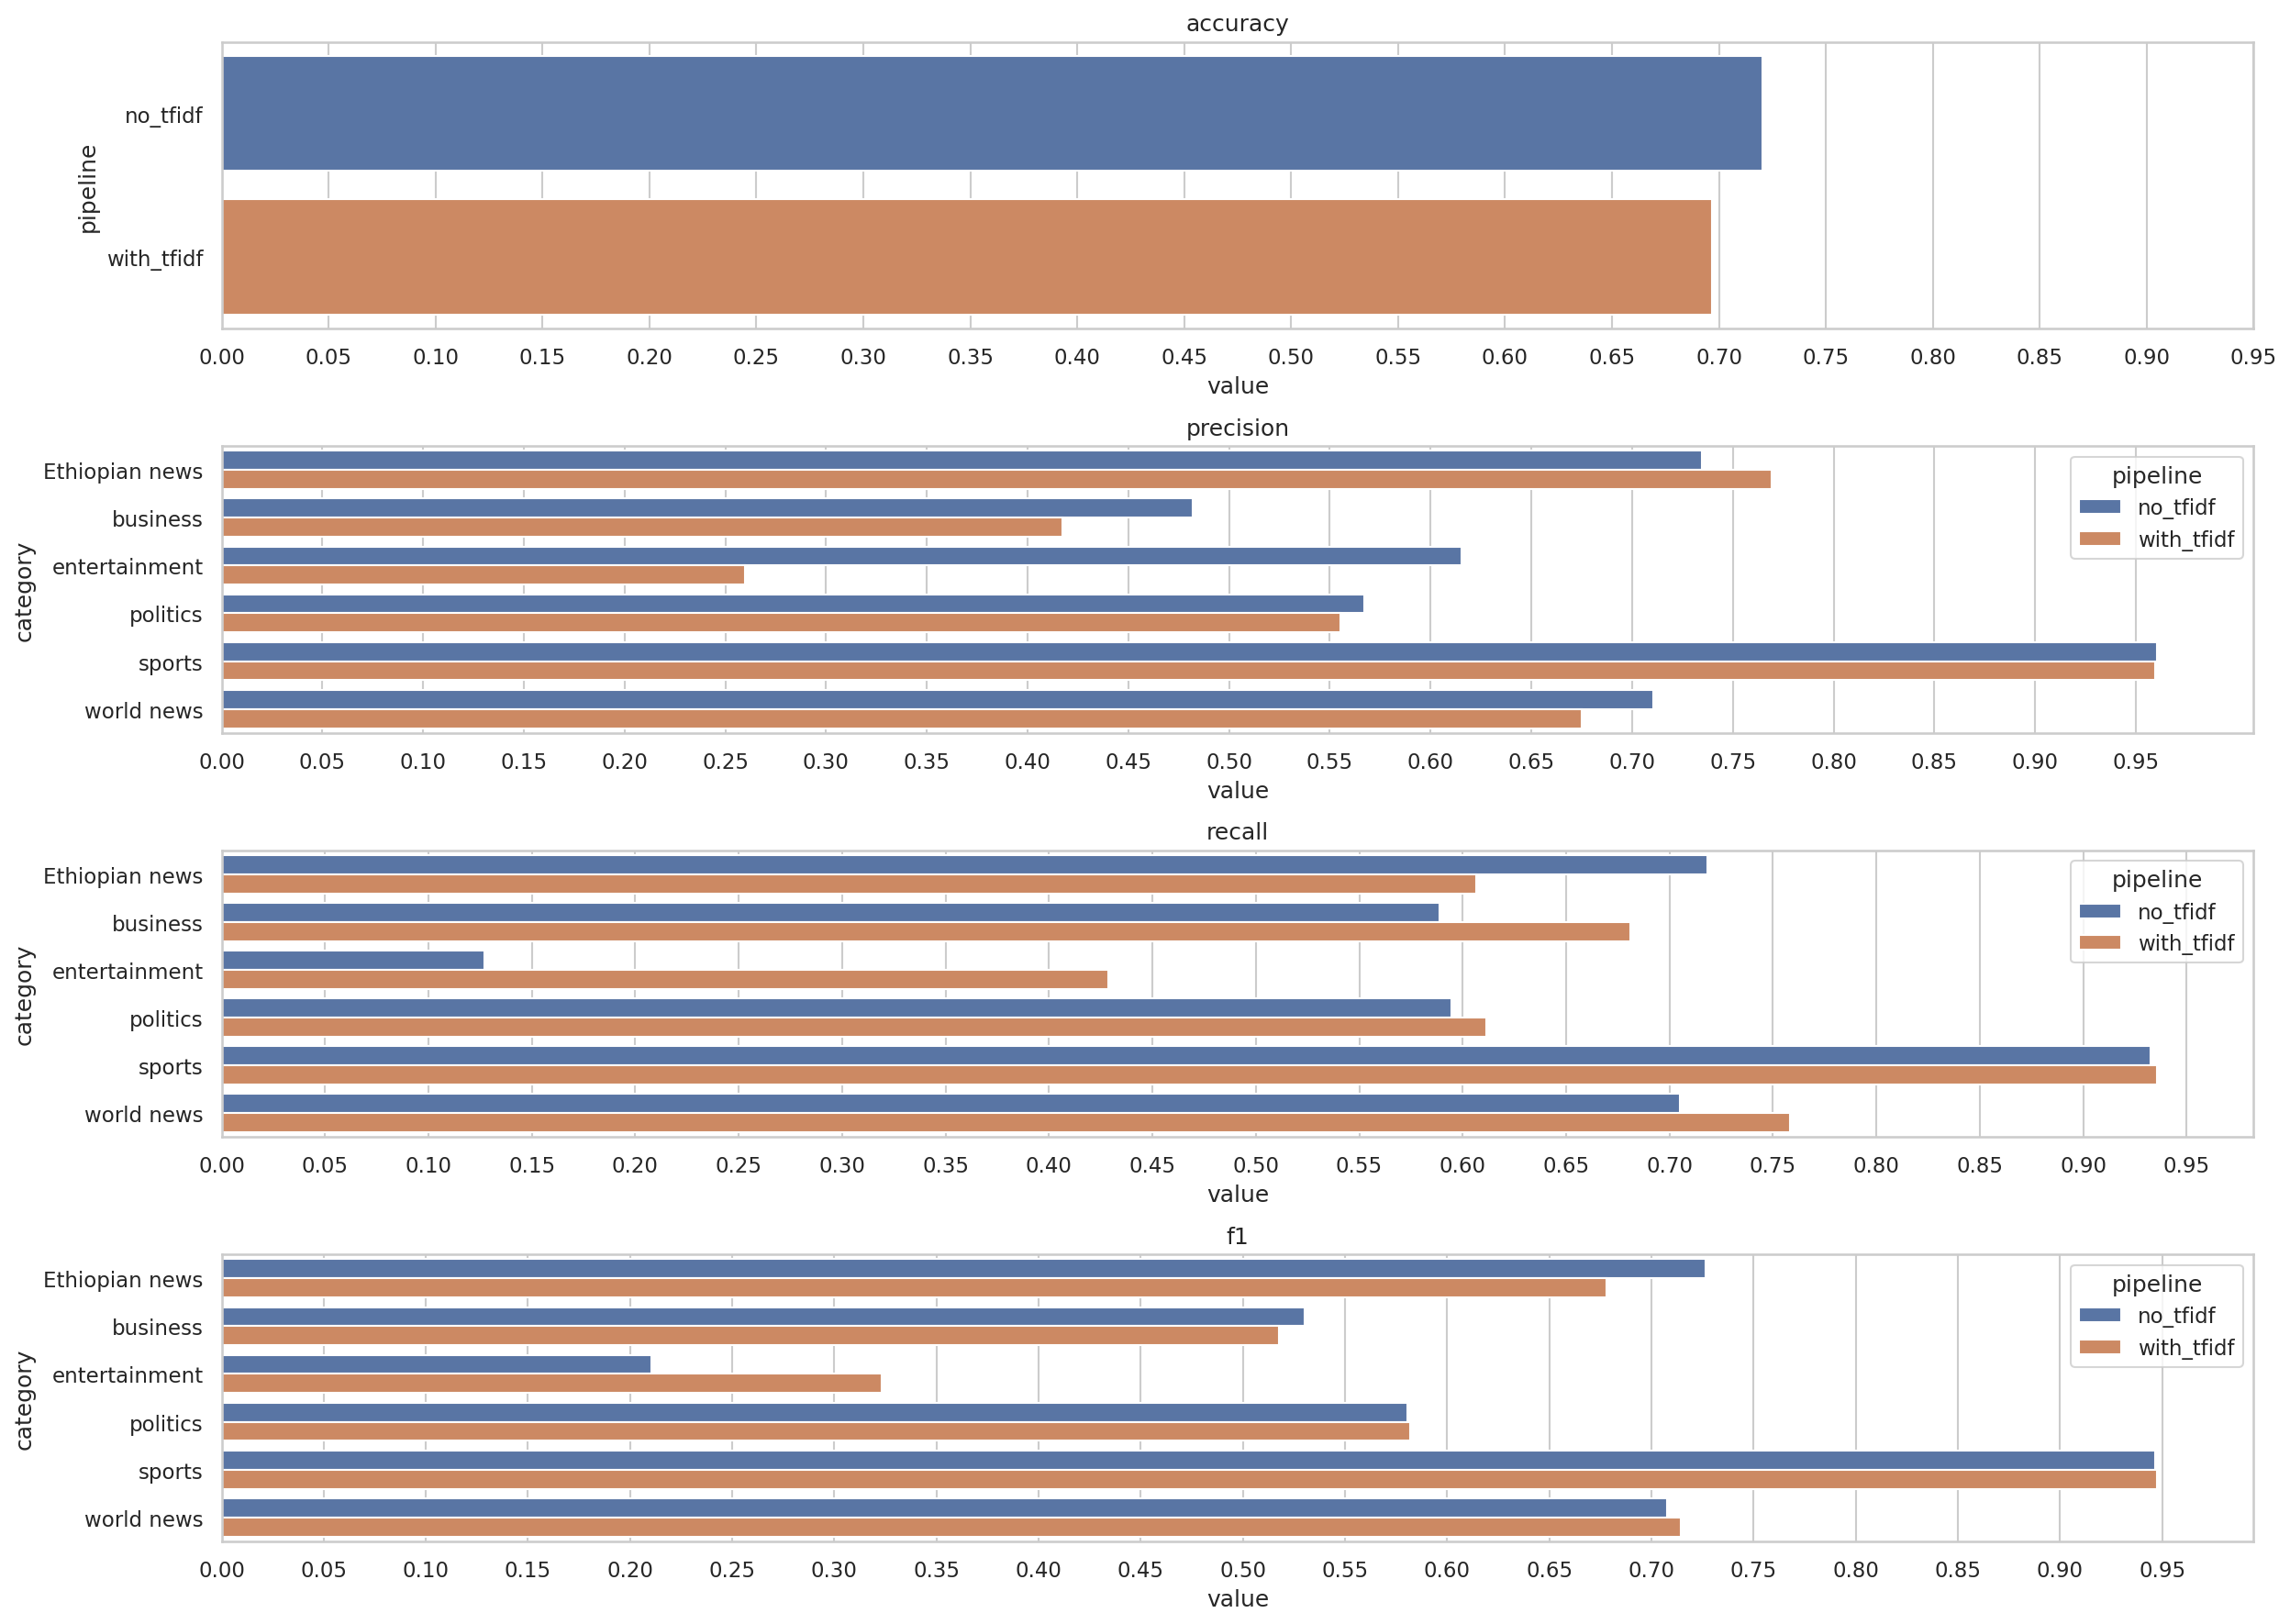

In [35]:
display_results_comparative(acc_arr=[acc_no_tfidf, acc_with_tfidf],
                            prf1_arr=[prf1_no_tfidf, prf1_with_tfidf],
                            desc_arr=[pipeline_no_tfidf.descr, pipeline_with_tfidf.descr])

## Application

Predicting labels for raw texts:

In [36]:
sample_texts = [
    # Ethiopian government: "We are working to bring peace"
    "የኢትዮጵያ መንግሥት \"ሰላም ለማምጣት እየሠራሁ ነው\" አለ",
    # Somalia's Hassan Sheikh Mohamud swears in
    "የሶማሊያው ሐሰን ሼኽ ሞሃሙድ ቃለ መሃላ ፈፀሙ",
    # Facebook fails again to detect hate speech in ads
    "ፌስቡክ የጥላቻ ንግግሮችን የያዙ ማስታወቂያዎችን ይለይ እንደሆነ በቀረበለት ፈተና እንደገና ወደቀ",
    # Ethiopia defeats Egypt 2-0 in Africa Cup of Nations qualifiers
    "ኢትዮጵያ በአፍሪካ ዋንጫ የማጣርያ ጨዋታ ግብፅን 2 - 0 አሸነፈች"
]
pred_labels_no_tfidf = pipeline.predict(sample_texts)
pred_labels_with_tfidf = pipeline_with_tfidf.predict(sample_texts)

Tokenising...:   0%|          | 0/4 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4 [00:00<?, ?it/s]

Tokenising...:   0%|          | 0/4 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
for text, label_no_tfidf, label_with_tfidf in zip(sample_texts,
                                                  pred_labels_no_tfidf,
                                                  pred_labels_with_tfidf):
    print("text:\t{}\nlabel (no tfidf):\t{}\nlabel (with tfidf):\t{}\n".format(text,
                                                                               label_no_tfidf,
                                                                               label_with_tfidf))

text:	የኢትዮጵያ መንግሥት "ሰላም ለማምጣት እየሠራሁ ነው" አለ
label (no tfidf):	Ethiopian news
label (with tfidf):	Ethiopian news

text:	የሶማሊያው ሐሰን ሼኽ ሞሃሙድ ቃለ መሃላ ፈፀሙ
label (no tfidf):	world news
label (with tfidf):	world news

text:	ፌስቡክ የጥላቻ ንግግሮችን የያዙ ማስታወቂያዎችን ይለይ እንደሆነ በቀረበለት ፈተና እንደገና ወደቀ
label (no tfidf):	world news
label (with tfidf):	world news

text:	ኢትዮጵያ በአፍሪካ ዋንጫ የማጣርያ ጨዋታ ግብፅን 2 - 0 አሸነፈች
label (no tfidf):	sports
label (with tfidf):	sports



Getting results as probability distributions over labels:

In [38]:
pipeline = pipeline_no_tfidf
pred_labels, pred_distrs, pred_text_outputs = pipeline.predict(sample_texts,
                                                               return_distributions=True,
                                                               get_results_as_text=True)

Tokenising...:   0%|          | 0/4 [00:00<?, ?it/s]

Preprocessing...:   0%|          | 0/4 [00:00<?, ?it/s]

Distributions contained in `dict` instances for further use:

In [39]:
for text, distr in zip(sample_texts, pred_distrs):
    print(text, distr)

የኢትዮጵያ መንግሥት "ሰላም ለማምጣት እየሠራሁ ነው" አለ {'Ethiopian news': 0.9876512247582953, 'business': 4.228217036036276e-05, 'entertainment': 2.142985105142751e-09, 'politics': 0.0015474003145194164, 'sports': 2.271853770707685e-10, 'world news': 0.010759090386654659}
የሶማሊያው ሐሰን ሼኽ ሞሃሙድ ቃለ መሃላ ፈፀሙ {'Ethiopian news': 1.9122700292685915e-05, 'business': 0.00017739788109609678, 'entertainment': 0.0021088069512050812, 'politics': 0.018512675387065892, 'sports': 2.1010051635944348e-05, 'world news': 0.9791609870287056}
ፌስቡክ የጥላቻ ንግግሮችን የያዙ ማስታወቂያዎችን ይለይ እንደሆነ በቀረበለት ፈተና እንደገና ወደቀ {'Ethiopian news': 0.028015104976500962, 'business': 0.04020004972355937, 'entertainment': 0.010035166935185599, 'politics': 0.08841895535379458, 'sports': 2.9327115536477597e-05, 'world news': 0.8333013958954225}
ኢትዮጵያ በአፍሪካ ዋንጫ የማጣርያ ጨዋታ ግብፅን 2 - 0 አሸነፈች {'Ethiopian news': 3.490002712401317e-08, 'business': 6.366829921897196e-07, 'entertainment': 3.04328148246039e-11, 'politics': 7.322882570185257e-08, 'sports': 0.999987089692

Information about the distribution returned as text:

In [40]:
for distr_descr in pred_text_outputs:
    print(distr_descr)

text: የኢትዮጵያ መንግሥት "ሰላም ለማምጣት እየሠራሁ ነው" አለ
----------------pipeline: no_tfidf----------------
predicted class: Ethiopian news
class probabilities: Ethiopian news: 98.77%	business: 0.00%	entertainment: 0.00%	politics: 0.15%	sports: 0.00%	world news: 1.08%

text: የሶማሊያው ሐሰን ሼኽ ሞሃሙድ ቃለ መሃላ ፈፀሙ
----------------pipeline: no_tfidf----------------
predicted class: world news
class probabilities: Ethiopian news: 0.00%	business: 0.02%	entertainment: 0.21%	politics: 1.85%	sports: 0.00%	world news: 97.92%

text: ፌስቡክ የጥላቻ ንግግሮችን የያዙ ማስታወቂያዎችን ይለይ እንደሆነ በቀረበለት ፈተ...
----------------pipeline: no_tfidf----------------
predicted class: world news
class probabilities: Ethiopian news: 2.80%	business: 4.02%	entertainment: 1.00%	politics: 8.84%	sports: 0.00%	world news: 83.33%

text: ኢትዮጵያ በአፍሪካ ዋንጫ የማጣርያ ጨዋታ ግብፅን 2 - 0 አሸነፈች
----------------pipeline: no_tfidf----------------
predicted class: sports
class probabilities: Ethiopian news: 0.00%	business: 0.00%	entertainment: 0.00%	politics: 0.00%	sports: 10